In [1]:
# 1. Download the datasets - Boston House pricing, Titanic survivors
# Do we do imputation? - No we skip for this excercise

# https://seaborn.pydata.org/tutorial/axis_grids.html

# 1. We are doing classification trees
#    Use Gini, Entropy gain, Information gain
#    Pruning


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations, product

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt

from utils import get_df_details, plot_distrb

from ucimlrepo import fetch_ucirepo 

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
cdc_diabetes_health_indicators.metadata

# Easy to understand data - => easier to sense check the result of the models
# Has a large data set
# Has mix of binary and integer data
# No missing data points
# The other dataset is coategorical dataset - has missing data
# Classification ouitcome is also binary

# Use phi coefficeint to find correlated data


{'uci_id': 891,
 'name': 'CDC Diabetes Health Indicators',
 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators',
 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv',
 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Tabular', 'Multivariate'],
 'num_instances': 253680,
 'num_features': 21,
 'feature_types': ['Categorical', 'Integer'],
 'demographics': ['Sex', 'Age', 'Education Level', 'Income'],
 'target_col': ['Diabetes_binary'],
 'index_col': ['ID'],
 'has_missing_values': 'no',
 'missing_values_symbol

In [4]:
X_summary = get_df_details(X)
X_summary = X_summary.merge(cdc_diabetes_health_indicators.variables.set_index('name'), how='outer', left_index=True, right_index=True)
X_summary

,count,mean,std,min,25%,50%,75%,max,nunique,n_nulls,dtype,role,type,demographic,description,units,missing_values
Age,253680.0,8.032119,3.054220,1.0,6.0,8.0,10.0,13.0,13.0,0.0,int64,Feature,Integer,Age,13-level age category (_AGEG5YR see codebook) ...,None,no
AnyHealthcare,253680.0,0.951053,0.215759,0.0,1.0,1.0,1.0,1.0,2.0,0.0,int64,Feature,Binary,None,"Have any kind of health care coverage, includi...",None,no
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0,84.0,0.0,int64,Feature,Integer,None,Body Mass Index,None,no
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0,2.0,0.0,int64,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
Diabetes_binary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
DiffWalk,253680.0,0.168224,0.374066,0.0,0.0,0.0,0.0,1.0,2.0,0.0,int64,Feature,Binary,None,Do you have serious difficulty walking or clim...,None,no
Education,253680.0,5.050434,0.985774,1.0,4.0,5.0,6.0,6.0,6.0,0.0,int64,Feature,Integer,Education Level,Education level (EDUCA see codebook) scale 1-6...,None,no
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0,2.0,0.0,int64,Feature,Binary,None,Consume Fruit 1 or more times per day 0 = no 1...,None,no
GenHlth,253680.0,2.511392,1.068477,1.0,2.0,2.0,3.0,5.0,5.0,0.0,int64,Feature,Integer,None,Would you say that in general your health is: ...,None,no
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0,2.0,0.0,int64,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no


In [5]:
X_summary.loc['GenHlth', 'description']

'Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor'

In [6]:
idx = cdc_diabetes_health_indicators['variables']['type'] == 'Integer'
int_cols = cdc_diabetes_health_indicators['variables'].loc[idx, 'name']
int_cols = int_cols.loc[~int_cols.isin(y.columns.tolist() + ['ID'])]

In [7]:
int_cols

5           BMI
15      GenHlth
16     MentHlth
17     PhysHlth
20          Age
21    Education
22       Income
Name: name, dtype: object

In [8]:
idx = cdc_diabetes_health_indicators['variables']['type'] == 'Binary'
bin_cols = cdc_diabetes_health_indicators['variables'].loc[idx, 'name']

bin_cols = bin_cols.loc[~bin_cols.isin(y.columns)]
bin_cols

2                   HighBP
3                 HighChol
4                CholCheck
6                   Smoker
7                   Stroke
8     HeartDiseaseorAttack
9             PhysActivity
10                  Fruits
11                 Veggies
12       HvyAlcoholConsump
13           AnyHealthcare
14             NoDocbcCost
18                DiffWalk
19                     Sex
Name: name, dtype: object

In [9]:
# This is an imbalance dataset - use F1 metric for evaluation
# If both False Negatives and False Positives are equally important then we use F1-Score
y.value_counts(normalize=True)
# sns.countplot(y)

Diabetes_binary
0                  0.860667
1                  0.139333
Name: proportion, dtype: float64

In [10]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# EDA - on the TRAIN data set
1. For the binary value to a % plot of distribution - note the ones that are very skewed
2. For the continuous data - do a violin plot distribution  - do we need normalisation here?
3. Do a correlation plot o

In [11]:

X_eda = X_train.copy()

In [12]:
X_melt = X_eda.melt(id_vars=['Age', 'Sex'], 
                var_name='metric')

In [13]:
X_eda.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)


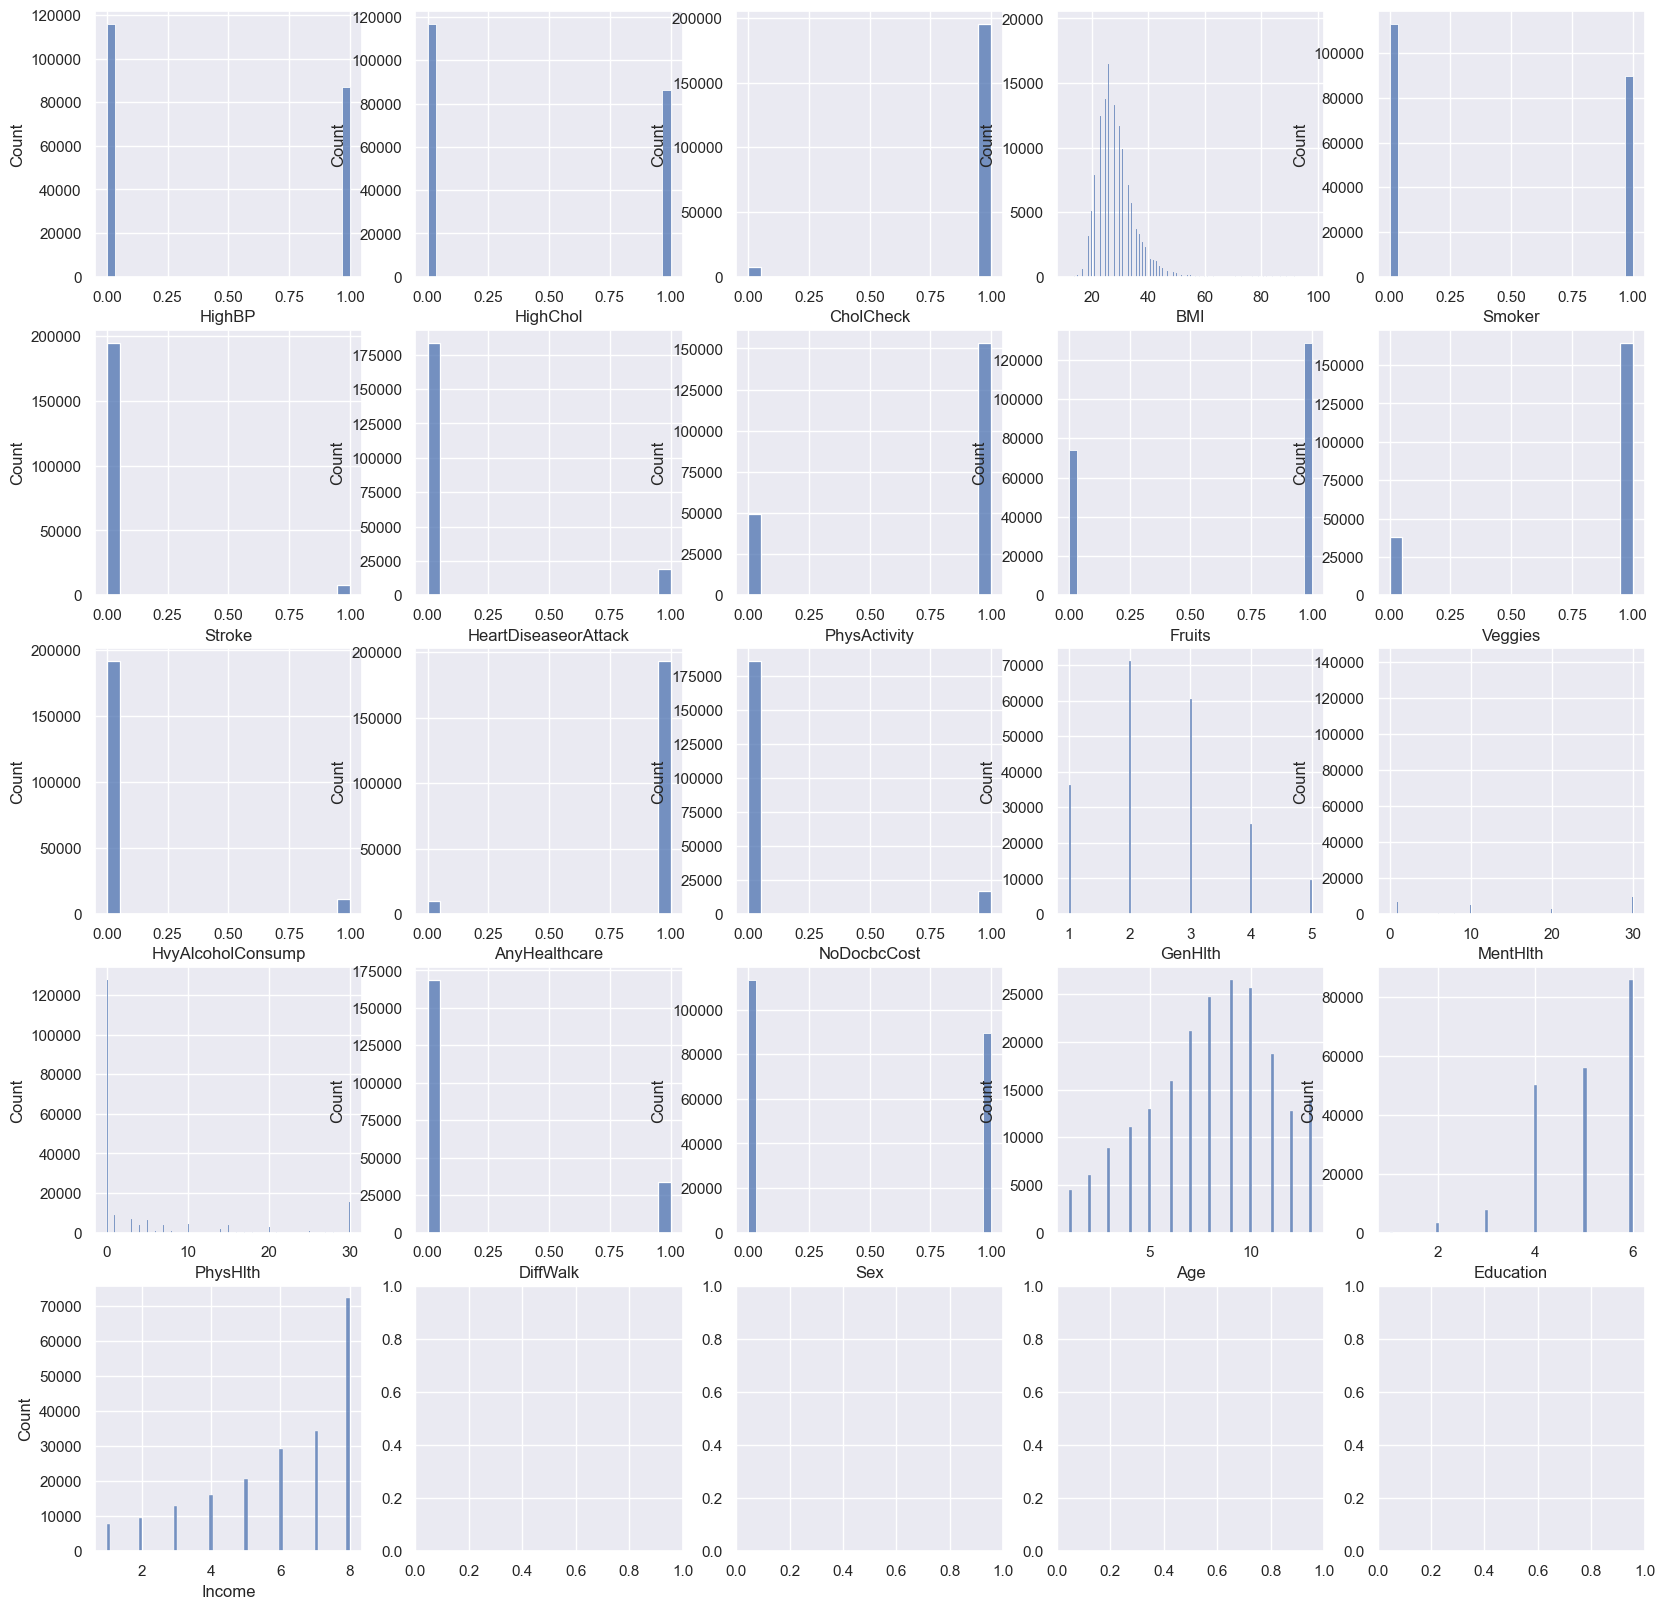

In [14]:
plot_distrb(X_eda)

<Axes: >

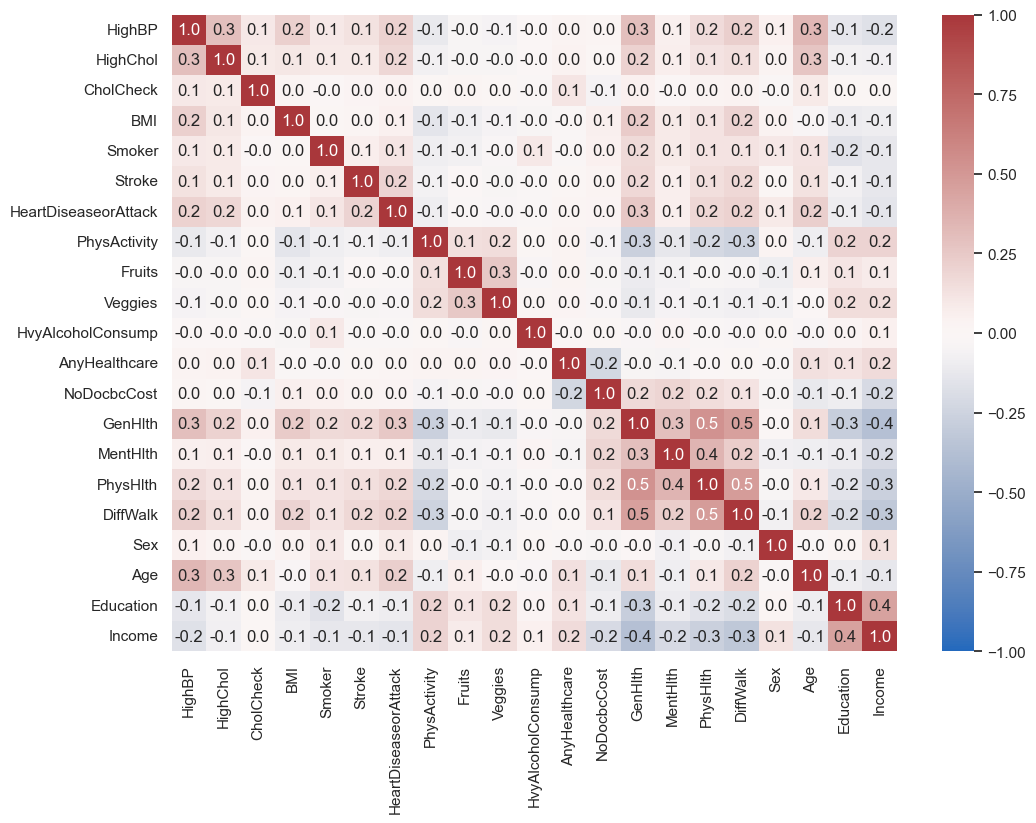

In [15]:
sns.heatmap(X_eda.corr(),annot=True, fmt=".1f", vmin=-1, vmax = 1, cmap='vlag')

In [16]:

X_int_melt = X_melt.query('metric in @int_cols')

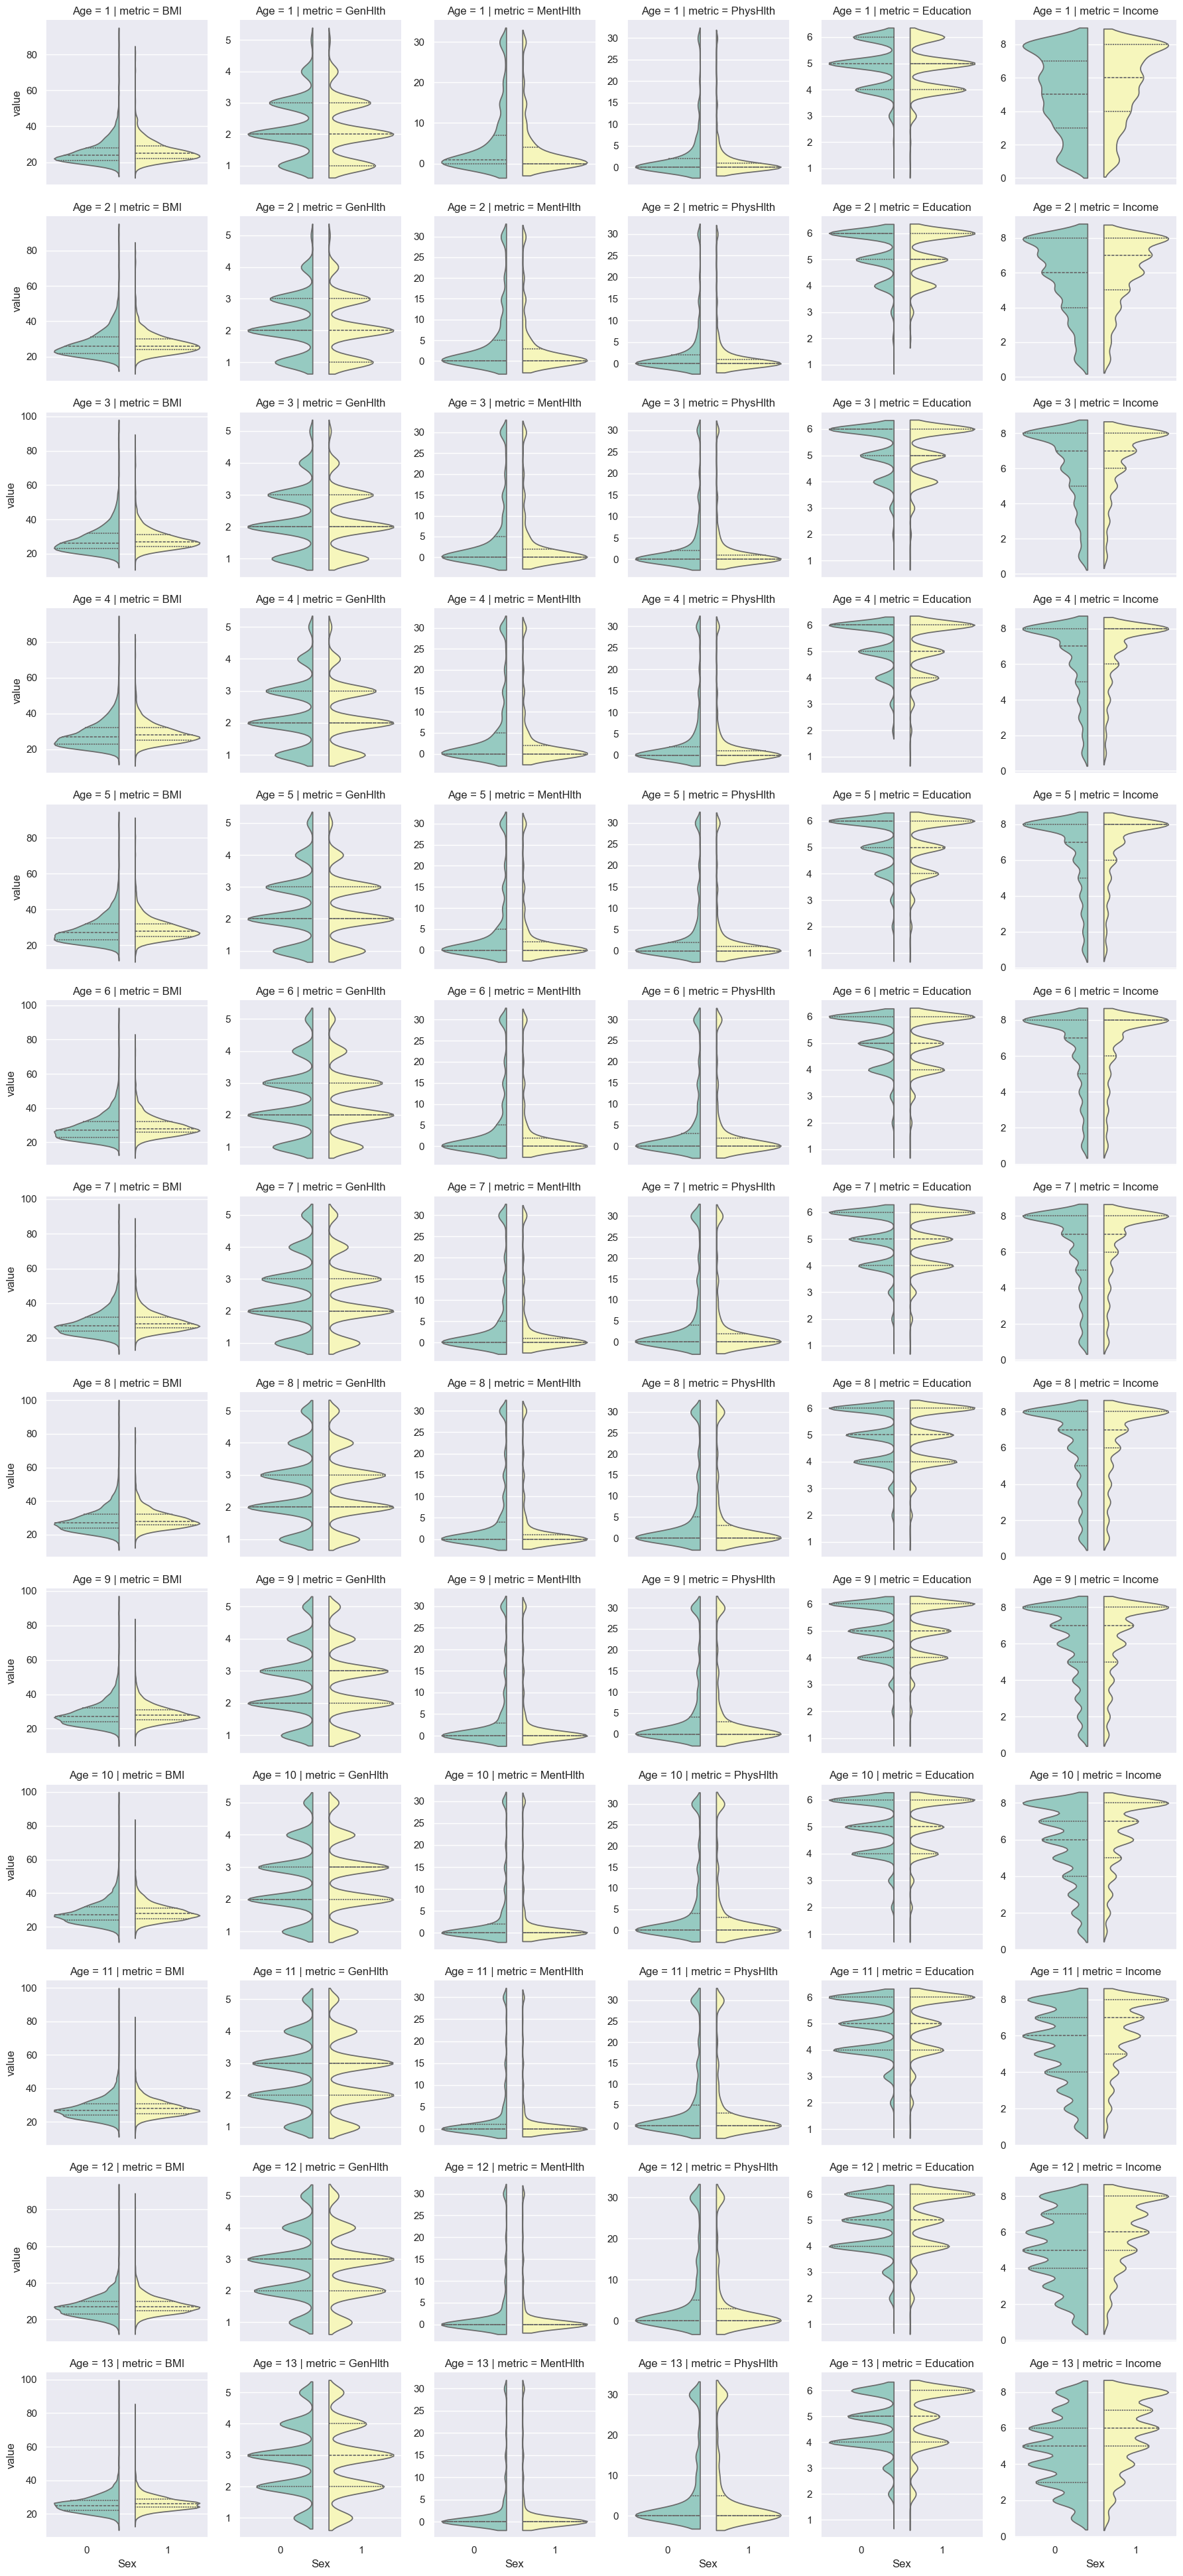

In [17]:

def _violinplot(x, y, hue,  **kwargs):
    """
    https://stackoverflow.com/a/44035405/6931113

    x: pd.series
    """
    sns.violinplot(x=x, y=y, hue=hue, **kwargs)

g = sns.FacetGrid(X_int_melt, row="Age", col='metric', sharey=False)
g.map(_violinplot, 'Sex',  "value", 'Sex', split=True, inner="quart", palette="Set3", order=[0, 1], legend=True)

In [18]:
cols = ['Age', 'Sex'] + bin_cols.tolist()
X_bin_melt = X_melt.query('metric in @bin_cols')

In [19]:
def _countplot(x, hue, palette='dark:#4c72b0', **kwargs):
    """
    https://stackoverflow.com/a/44035405/6931113

    x: pd.series
    """
    sns.countplot(x=x, hue=hue, palette=palette, **kwargs)

    
def plot_countplot(X_melt):
    """
        https://stackoverflow.com/a/69813924/6931113
    """
    g = sns.FacetGrid(X_melt, row="Age", col="metric")
    g.map(_countplot, "value", "Sex", order=[0, 1], stat='percent')
    g.set_xticklabels(['No', 'Yes'])
    g.set_titles("Age = {row_name} | metric = {col_name}")
    g.set_axis_labels("", "Percentage")
    g.add_legend()
    # g.fig.subplots_adjust(wspace=.02)
    # g.fig.suptitle('Countplot of X_melt by metric')
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    return ax


<Axes: title={'center': 'Age = 13 | metric = DiffWalk'}>

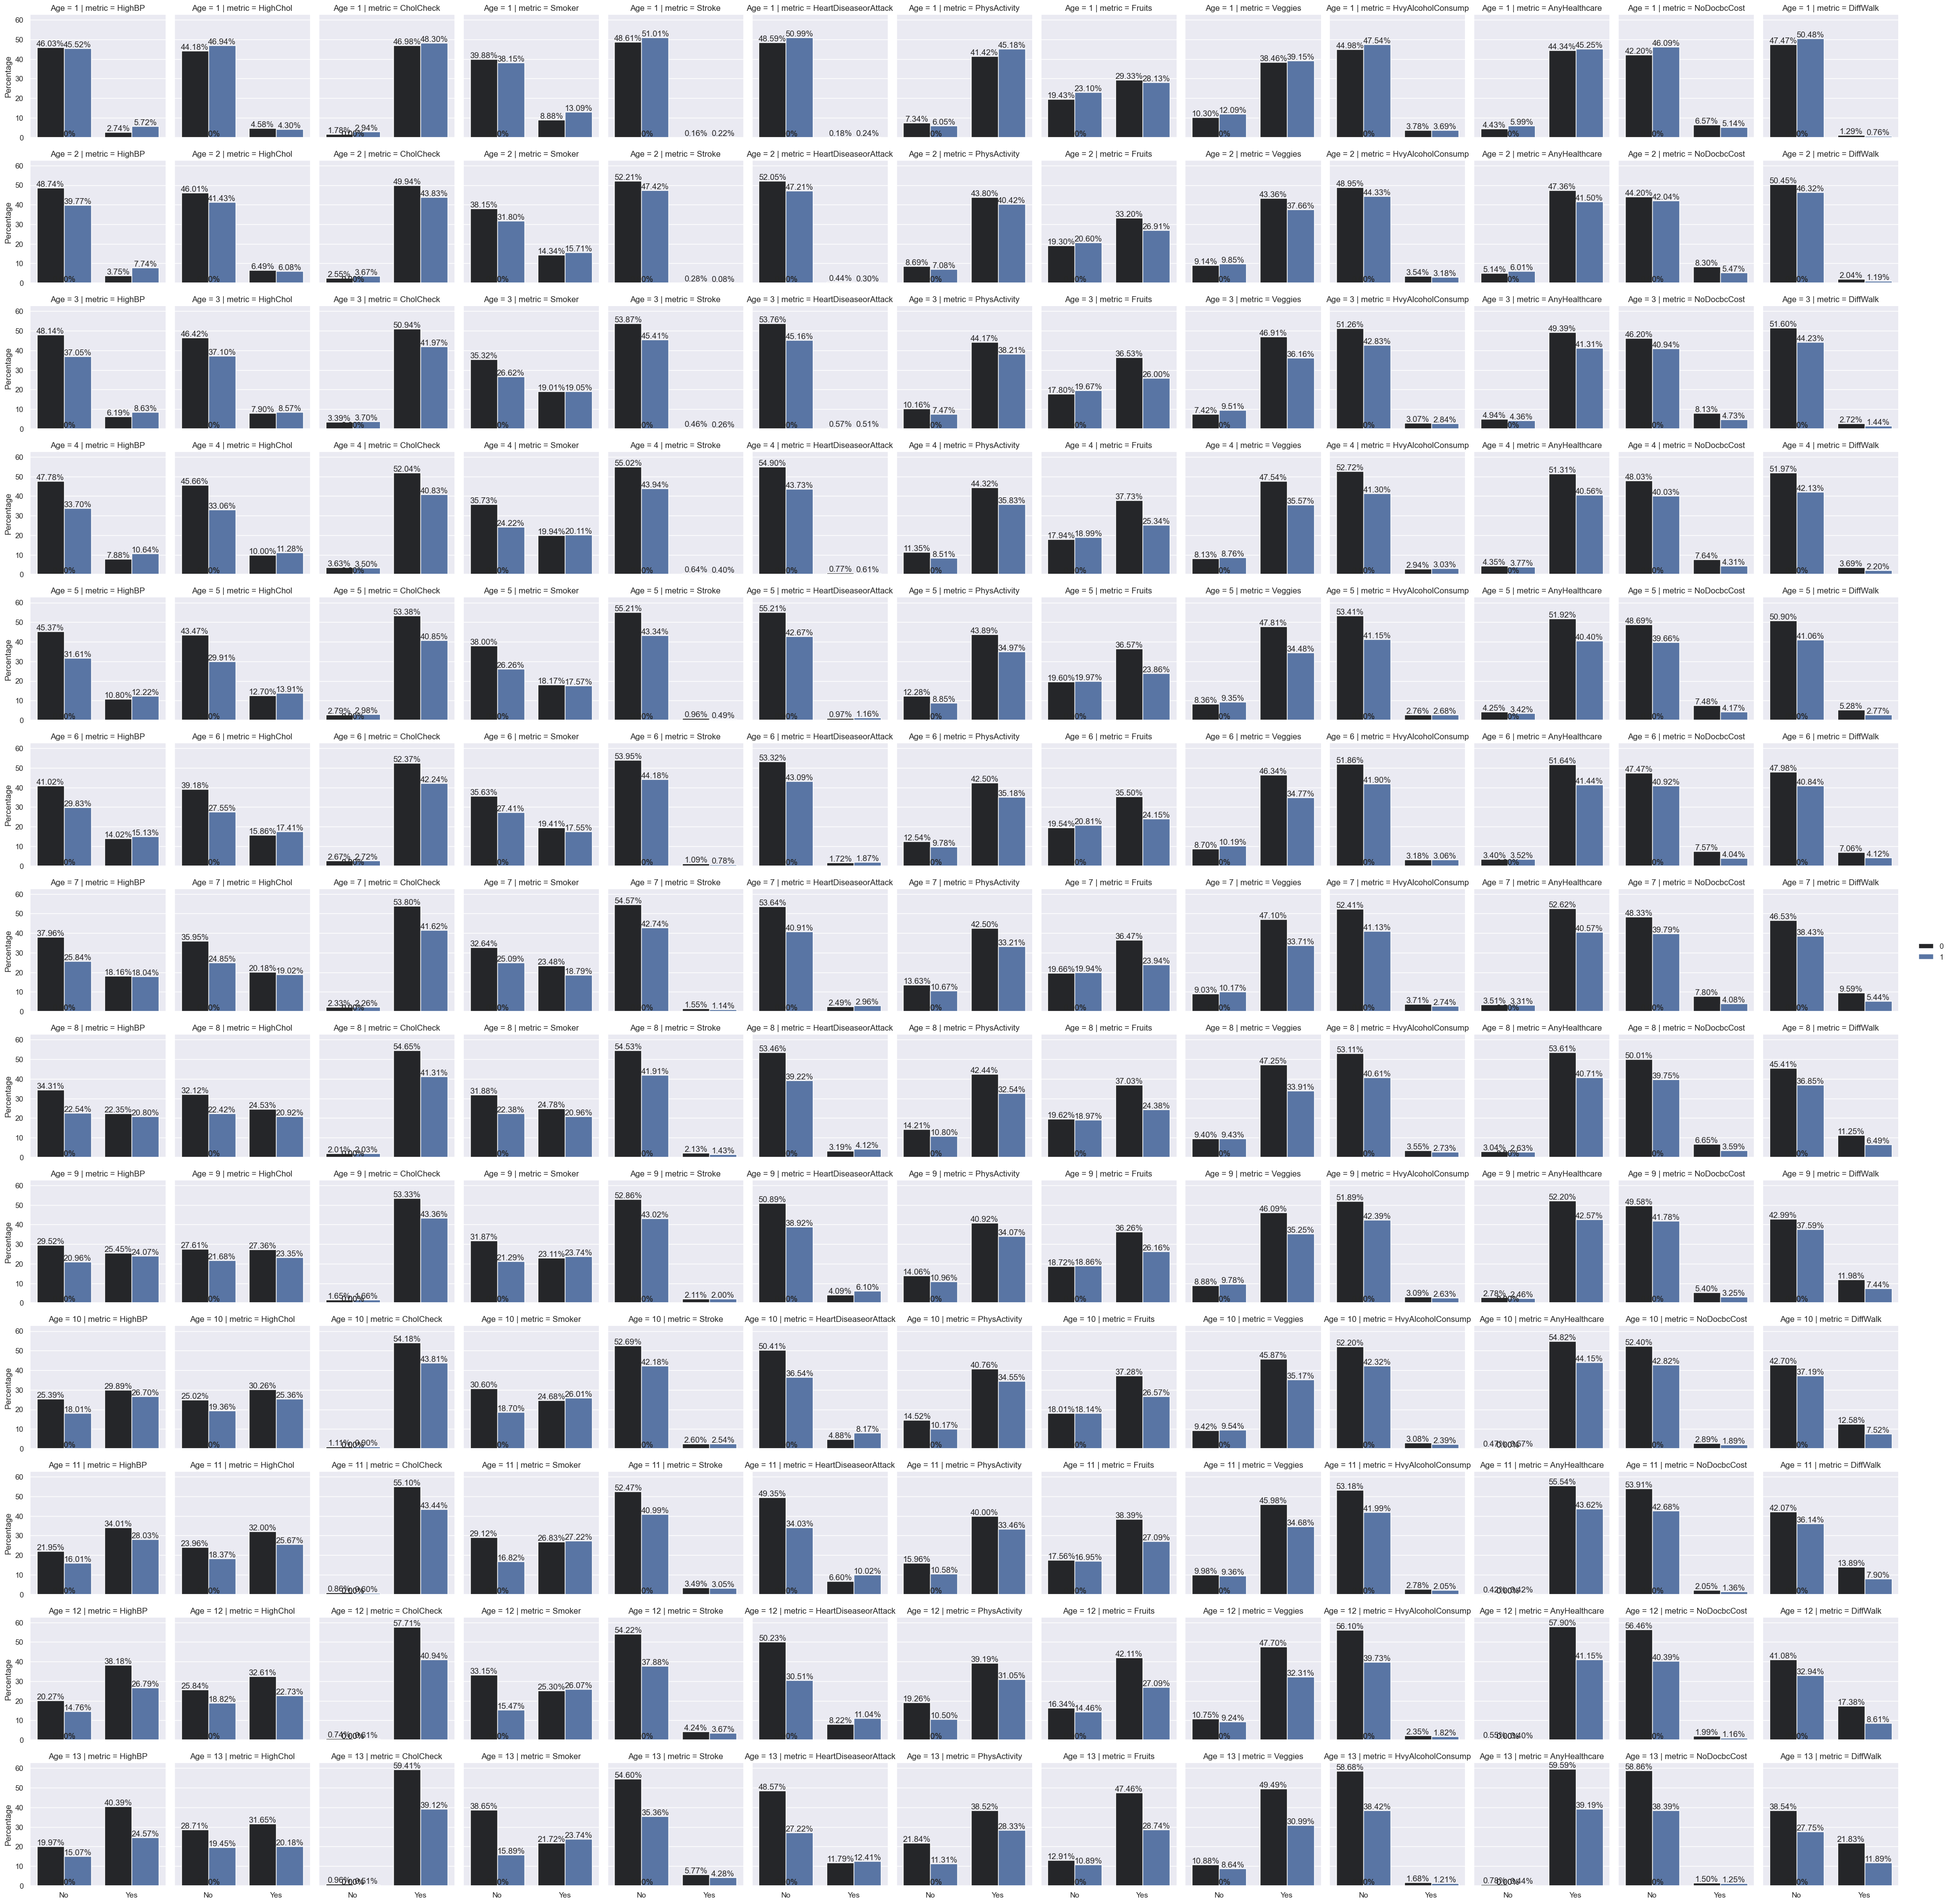

In [20]:
plot_countplot(X_bin_melt)

In [21]:
X_train.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [22]:
#  Need to do one hot encoding for the categorical data
# https://www.freecodecamp.org/news/machine-learning-pipeline/

# We dont do imputatuon - drop the missing data to keep it simple
# Which columns to onehot encode - Income, Education, Age, GenHealth

RANDOM_STATE = 42
N_FOLDS = 10
N_JOBS = -1
SCORING = 'f1'

num_cols = ['BMI', 'MentHlth', 'PhysHlth']
cat_cols = bin_cols.tolist() + ['Income', 'Education', 'Age', 'GenHlth']

num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



In [23]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'DiffWalk',
                                                   'Sex', 'Income', 'Education',
                                                   'Age', 'GenHlth'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [24]:
# Since imbalanced dataset, use F1 score
from sklearn.metrics import f1_score

score = clf_pipeline.score(X_test, y_test)
print(f"Model score: {score}") # model accuracy

Model score: 0.7978752759381899


In [25]:
# tuning the variables
from sklearn.model_selection import GridSearchCV

#    Use Gini, Entropy gain, Information gain
#    Pruning

grid_params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 7, 11],
    'model__min_samples_split': [2, 6, 10, 100],
    'model__min_samples_leaf': [1, 5, 10, 100]
}

gs = GridSearchCV(clf_pipeline, grid_params, cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=4,
                  return_train_score=True)
gs.fit(X_train, y_train)

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best Score of train set: 0.24537325985915523
Best parameter set: {'model__criterion': 'gini', 'model__max_depth': 11, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Test Score: 0.21049099653282627


In [26]:
# from sklearn import tree
# tree.plot_tree(clf_pipeline.named_steps['model'], filled=True)

[Text(0.5146969429866894, 0.9893617021276596, 'x[3] <= 0.5\ngini = 0.24\nsamples = 202944\nvalue = [174667, 28277]'),
 Text(0.27180206453941896, 0.9680851063829787, 'x[15] <= 0.5\ngini = 0.113\nsamples = 115882\nvalue = [108898, 6984]'),
 Text(0.21535126249019734, 0.9468085106382979, 'x[47] <= 0.5\ngini = 0.093\nsamples = 104835\nvalue = [99735, 5100]'),
 Text(0.15749526786426085, 0.925531914893617, 'x[46] <= 0.5\ngini = 0.082\nsamples = 99349\nvalue = [95108, 4241]'),
 Text(0.10573929515193997, 0.9042553191489362, 'x[48] <= 0.5\ngini = 0.052\nsamples = 73412\nvalue = [71458, 1954]'),
 Text(0.07961132249858363, 0.8829787234042553, 'x[0] <= 0.192\ngini = 0.048\nsamples = 72469\nvalue = [70670, 1799]'),
 Text(0.04610718894156269, 0.8617021276595744, 'x[4] <= 0.5\ngini = 0.035\nsamples = 54230\nvalue = [53267, 963]'),
 Text(0.03228927817156216, 0.8404255319148937, 'x[43] <= 0.5\ngini = 0.025\nsamples = 40930\nvalue = [40409, 521]'),
 Text(0.021853647030955856, 0.8191489361702128, 'x[45] <

Error in callback <function _draw_all_if_interactive at 0x0000025CA5B145E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
gs.cv_results_.keys()

gs.cv_results_['mean_test_score']


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)
conf_matrix

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions),
          'recall_score':recall_score(y_test, y_test_predictions),
          'f1_score':f1_score(y_test, y_test_predictions)
}

print(scores)
# target_names=target_names
print(classification_report(y_test, y_test_predictions))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.show()

In [ ]:
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

# plot precison recall curve


In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": StratifiedKFold(n_splits=N_FOLDS, test_size=0.2, random_state=RANDOM_STATE),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1",
}

for ax_idx, estimator in enumerate([clf_pipeline]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html